In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import torch
import numpy as np
import pandas as pd
import meerkat as mk
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dcbench import SliceDiscoverySolution

from domino.eval.metrics import compute_solution_metrics
from domino import explore, KCenterMixtureSlicer

In [3]:
import os
# os.environ["DCBENCH_CONFIG"] = "/home/sabri/code/dcbench/dcbench-config.yaml"
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

from tqdm import tqdm

import dcbench
sd = dcbench.tasks["slice_discovery"]

In [4]:
sd.problems

,alpha,dataset,n_pred_slices,slice_category,slice_names,target_name
p_72776,0.2000,celeba,5,correlation,"[wearing_lipstick=0_young=1, wearing_lipstick=...",wearing_lipstick
p_72793,0.6000,celeba,5,correlation,"[wearing_necklace=0_black_hair=1, wearing_neck...",wearing_necklace
p_72800,0.2000,celeba,5,correlation,"[wearing_necklace=0_brown_hair=1, wearing_neck...",wearing_necklace
p_72799,0.6000,celeba,5,correlation,"[wearing_necklace=0_smiling=1, wearing_necklac...",wearing_necklace
p_72802,0.2000,celeba,5,correlation,"[wearing_necklace=0_wearing_lipstick=1, wearin...",wearing_necklace
...,...,...,...,...,...,...
p_122649,0.2000,imagenet,5,noisy_label,[watch.n.01],timepiece.n.01
p_117333,0.0500,imagenet,5,rare,[cart.n.01],vehicle.n.01
p_118951,0.0500,imagenet,5,rare,[punch.n.02],food.n.01
p_120032,0.0500,imagenet,5,rare,[mushroom.n.05],vegetable.n.01


In [5]:
def get_slices(tasks, slice_type='rare'):
    ids = []
    print(f'Collecting {slice_type} slices:')
    for id in tqdm(tasks):
        if tasks[id]._attributes['slice_category'] == slice_type:
            ids.append(id)
    return ids

In [6]:
rare_tasks = get_slices(sd.problems, slice_type='rare')

100%|█████████████████████████████████████| 886/886 [00:00<00:00, 970021.76it/s]


In [7]:
len(rare_tasks), rare_tasks[-5:]

(118, ['p_121242', 'p_117333', 'p_118951', 'p_120032', 'p_118660'])

In [4]:
task = 'p_121301'
print(sd.problems[task]._attributes)
problem = sd.problems[task]

{'alpha': 0.01709975946676697, 'dataset': 'imagenet', 'n_pred_slices': 5, 'slice_category': 'rare', 'slice_names': ['lion.n.01'], 'target_name': 'big_cat.n.01'}


In [5]:
problem

SliceDiscoveryProblem(artifacts={'activations': 'DataPanelArtifact', 'base_dataset': 'VisionDatasetArtifact', 'clip': 'DataPanelArtifact', 'model': 'ModelArtifact', 'test_predictions': 'DataPanelArtifact', 'test_slices': 'DataPanelArtifact', 'val_predictions': 'DataPanelArtifact'}, attributes={'alpha': 0.01709975946676697, 'dataset': 'imagenet', 'n_pred_slices': 5, 'slice_category': 'rare', 'slice_names': ['lion.n.01'], 'target_name': 'big_cat.n.01'})

In [6]:
problem['test_slices']

,id (PandasSeriesColumn),slices (NumpyArrayColumn)
0,n04399382_22356,[0.0]
1,n02128925_16657,[0.0]
2,n02130308_2741,[0.0]
3,n02128385_16927,[0.0]
4,n03045698_6258,[0.0]
...,...,...
5919,n07768694_15505,[0.0]
5920,n07716358_34090,[0.0]
5921,n02488702_1954,[0.0]
5922,n02129604_9992,[0.0]


In [7]:
problem['test_predictions']

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ml/__init__.py:7: ExperimentalWarning: The `meerkat.ml` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


,id (PandasSeriesColumn),target (NumpyArrayColumn),probs (ClassificationOutputColumn),split (PandasSeriesColumn)
0,n04399382_22356,0,"[tensor(0.9981), tensor(0.0019)]",test
1,n02128925_16657,1,"[tensor(0.0013), tensor(0.9987)]",test
2,n02130308_2741,1,"[tensor(1.5861e-07), tensor(1.0000)]",test
3,n02128385_16927,1,"[tensor(0.0013), tensor(0.9987)]",test
4,n03045698_6258,0,"[tensor(0.9416), tensor(0.0584)]",test
...,...,...,...,...
5919,n07768694_15505,0,"[tensor(0.9995), tensor(0.0005)]",test
5920,n07716358_34090,0,"[tensor(0.9834), tensor(0.0166)]",test
5921,n02488702_1954,0,"[tensor(0.9792), tensor(0.0208)]",test
5922,n02129604_9992,1,"[tensor(0.0018), tensor(0.9982)]",test


In [8]:
problem['val_predictions']

,id (PandasSeriesColumn),target (NumpyArrayColumn),probs (ClassificationOutputColumn),split (PandasSeriesColumn)
0,n02099267_2491,0,"[tensor(0.9763), tensor(0.0237)]",valid
1,n02168699_7820,0,"[tensor(0.9982), tensor(0.0018)]",valid
2,n04328186_4646,0,"[tensor(0.9759), tensor(0.0241)]",valid
3,n02130308_13202,1,"[tensor(0.0036), tensor(0.9964)]",valid
4,n02130308_20653,1,"[tensor(1.8196e-05), tensor(1.0000)]",valid
...,...,...,...,...
2985,n03089624_25757,0,"[tensor(0.9818), tensor(0.0182)]",valid
2986,n02089973_1076,0,"[tensor(0.9781), tensor(0.0219)]",valid
2987,ILSVRC2012_val_00014212,0,"[tensor(0.8937), tensor(0.1063)]",valid
2988,n01729977_8550,0,"[tensor(0.9555), tensor(0.0445)]",valid


In [9]:
test_dp = mk.merge(problem["test_slices"], problem["test_predictions"], on="id")
test_dp = mk.merge(problem["base_dataset"], test_dp, on="id")
test_dp["pred"] = test_dp["probs"][:, 1]

val_dp = mk.merge(problem["val_predictions"], problem["base_dataset"], on="id") 
val_dp["pred"] = val_dp["probs"][:, 1]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


## Embed Images

In [10]:
from domino import embed
val_dp = embed(
    val_dp, 
    input_col="image",
    device=0
)
test_dp = embed(
    test_dp, 
    input_col="image",
    device=0
)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

In [11]:
test_dp.columns

['id',
 'image',
 'name',
 'synset',
 'slices',
 'target',
 'probs',
 'split',
 'pred',
 'clip(image)']

## Slice

In [16]:
kcenter_config = {
    'n_slices': 25,
    'n_mixture_components': 25,
    'max_iter': 1,
    'y_log_likelihood_weight': 100,
    'y_hat_log_likelihood_weight': 100
}
kcenter = KCenterMixtureSlicer(
    **kcenter_config
)

In [17]:
kcenter.fit(data=val_dp, embeddings="clip(image)", targets="target", pred_probs="pred")

Initializing with k-center clustering.


  0%|          | 0/1 [00:00<?, ?it/s]

/home/namratadeka/projects/slice-discovery/domino/examples/../domino/_slice/kcenter_mm.py:604: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  "Try different init parameters, "


KCenterMixtureSlicer(max_iter=1, n_slices=25, y_hat_log_likelihood_weight=100,
                     y_log_likelihood_weight=100)

In [18]:
result = mk.DataPanel({"id": test_dp["id"]})

In [19]:
result['slice_preds'] = kcenter.predict(
        test_dp, embeddings="clip(image)", targets="target", pred_probs="pred"
    )
result['slice_probs'] = kcenter.predict_proba(
        test_dp, embeddings="clip(image)", targets="target", pred_probs="pred"
    )

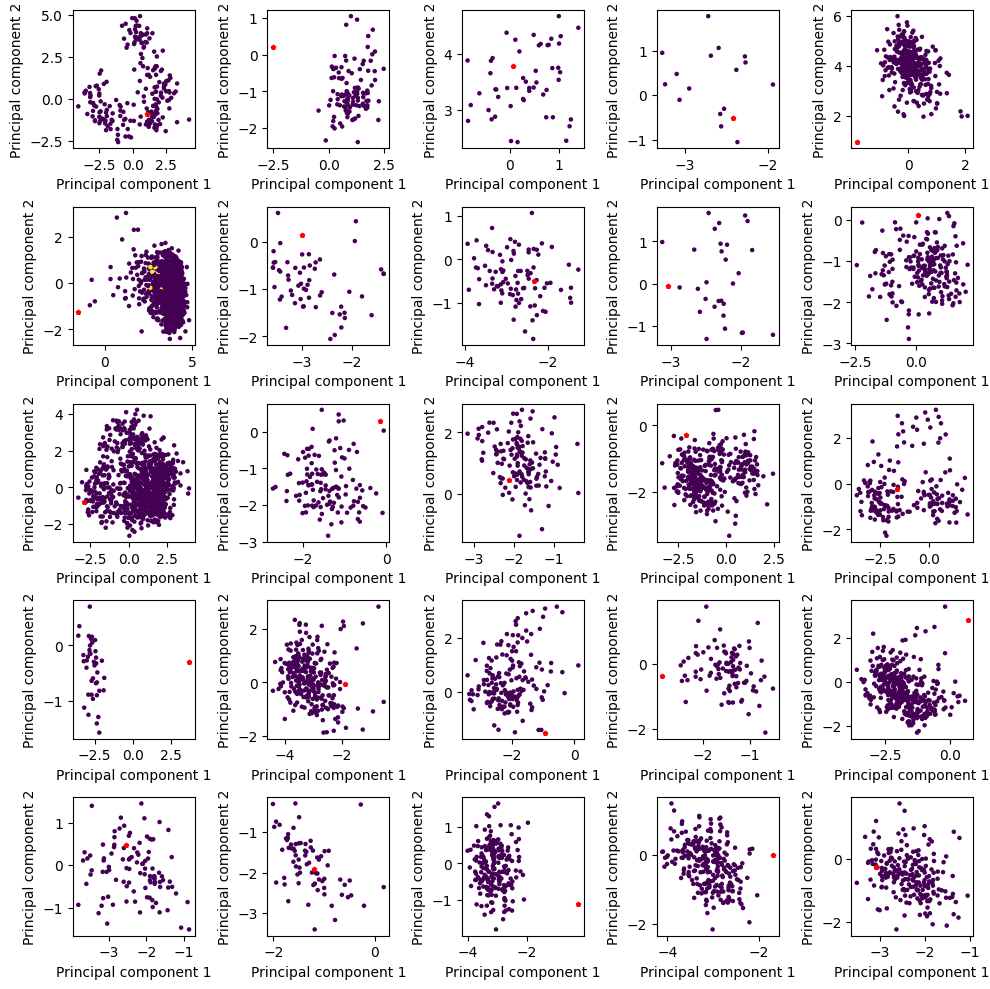

In [20]:
pca = PCA(n_components=2)
test_X = kcenter.pca.transform(test_dp['clip(image)'])
test_X = pca.fit_transform(np.vstack([test_X, kcenter.mm.means_]))
centers = test_X[-kcenter.config.n_slices:]
test_X = test_X[:-kcenter.config.n_slices]

plt.figure(figsize=(10, 10))
for i in range(kcenter.config.n_slices):
    plt.subplot(5, 5, i+1)
    cluster = i
    points = test_X[result['slice_preds'].argmax(axis=1)==cluster]
    colors = test_dp[result["slice_preds"].argmax(axis=1)==cluster]['slices'].reshape(-1,)

    plt.scatter(points[:,0], points[:, 1], s=5, c=colors)
    plt.scatter(centers[cluster, 0], centers[cluster, 1], s=10, c='r', marker='p', label='cluster centers')
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    # plt.legend()
plt.tight_layout()
plt.show()

## Embed Text

In [ ]:
from domino import generate_candidate_descriptions
phrase_templates = [
    "a photo of [MASK].",
    "a photo of {} [MASK].",
    "a photo of [MASK] {}.",
    "a photo of [MASK] {} [MASK].",
]

text_dp = generate_candidate_descriptions(
    templates=phrase_templates,
    num_candidates=10_000
)

[nltk_data] Downloading package words to
[nltk_data]     /home/namratadeka/nltk_data...
[nltk_data]   Package words is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
text_dp = embed(
    text_dp, 
    input_col="output_phrase", 
    encoder="clip",
    device=0
)

In [34]:
test_dp['kcenter_slices'] = result["slice_preds"]
explore(
    data=test_dp,
    embeddings="clip(image)",
    pred_probs="probs",
    targets="target",
    slices="kcenter_slices",
    text=text_dp,
    text_embeddings="clip(output_phrase)",
) 

FloatSlider(value=0.5, continuous_update=False, description='Slice Inclusion Threshold', max=1.0, readout_form…

Output()

In [35]:
solution = SliceDiscoverySolution(
    artifacts={
        "pred_slices": result,
    },
    attributes={
        "problem_id": problem.id,
        "slicer_class": KCenterSlicer,
        "slicer_config": kcenter_config,
        "embedding_column": 'clip(image)',
    },
)
metrics = compute_solution_metrics(
    solution,
)

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


In [36]:
metrics

[{'target_slice_idx': 0,
  'target_slice_name': 'lion.n.01',
  'pred_slice_idx': 10,
  'average_precision': 0.009781790820165538,
  'precision-at-10': 0.0,
  'precision-at-25': 0.0,
  'precision': 0.009781790820165538,
  'recall': 1.0,
  'f1_score': 0.019374068554396422,
  'support': None,
  'solution_id': '1bb4e667d2f54f82af355747155f069a',
  'problem_id': 'p_121301'}]

In [37]:
pred_slices = result["slice_preds"].argmax(axis=1)

In [38]:
np.unique(pred_slices[np.where(test_dp['slices'] == 1)[0]])

array([10])

,id (PandasSeriesColumn),image (ListColumn),name (PandasSeriesColumn),synset (PandasSeriesColumn),slices (NumpyArrayColumn),target (NumpyArrayColumn),probs (ClassificationOutputColumn),split (PandasSeriesColumn),pred (ClassificationOutputColumn),clip(image) (NumpyArrayColumn),kcenter_slices (NumpyArrayColumn)
0,n02128385_10108,,"leopard, Panthera pardus",n02128385,[0.0],1,"[tensor(9.6842e-05), tensor(0.9999)]",test,tensor(0.9999),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
1,n02128385_10229,,"leopard, Panthera pardus",n02128385,[0.0],1,"[tensor(0.0303), tensor(0.9697)]",test,tensor(0.9697),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
2,n02128385_10294,,"leopard, Panthera pardus",n02128385,[0.0],1,"[tensor(1.5146e-07), tensor(1.0000)]",test,tensor(1.0000),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
3,n02128385_10350,,"leopard, Panthera pardus",n02128385,[0.0],1,"[tensor(0.0003), tensor(0.9997)]",test,tensor(0.9997),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
4,n02128385_1035,,"leopard, Panthera pardus",n02128385,[0.0],1,"[tensor(1.7695e-05), tensor(1.0000)]",test,tensor(1.0000),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
...,...,...,...,...,...,...,...,...,...,...,...
1324,ILSVRC2012_val_00038707,,"cheetah, chetah, Acinonyx jubatus",n02130308,[0.0],1,"[tensor(3.2157e-05), tensor(1.0000)]",test,tensor(1.0000),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
1325,ILSVRC2012_val_00002557,,"snow leopard, ounce, Panthera uncia",n02128757,[0.0],1,"[tensor(0.0004), tensor(0.9996)]",test,tensor(0.9996),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
1326,ILSVRC2012_val_00031017,,"tiger, Panthera tigris",n02129604,[0.0],1,"[tensor(0.0050), tensor(0.9950)]",test,tensor(0.9950),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
1327,ILSVRC2012_val_00032038,,"tiger, Panthera tigris",n02129604,[0.0],1,"[tensor(0.0186), tensor(0.9814)]",test,tensor(0.9814),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"

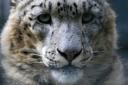
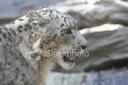
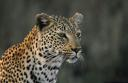
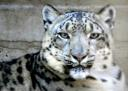
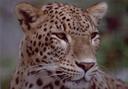
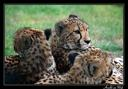
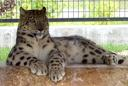
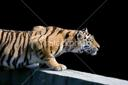
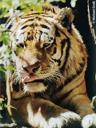
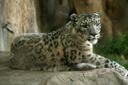

In [39]:
test_dp[pred_slices==10]

In [124]:
from scipy.stats import t

def bootstrap_ci(x, confidence):
    values = [np.random.choice(x,size=len(x),replace=True).mean() for i in range(1000)]
    
    return np.percentile(values,[100*(1-confidence)/2,100*(1-(1-confidence)/2)])

def ci(x, confidence):
    m = x.mean()
    s = x.std()
    dof = len(x) - 1
    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    return (m-s*t_crit/np.sqrt(len(x)), m+s*t_crit/np.sqrt(len(x)))

In [125]:
metrics = ['precision-at-10', 'precision-at-25', 'precision', 'recall']
xpos = np.arange(len(metrics))
shift = {
    'domino': -0.2,
    'kcenter': 0.2
}

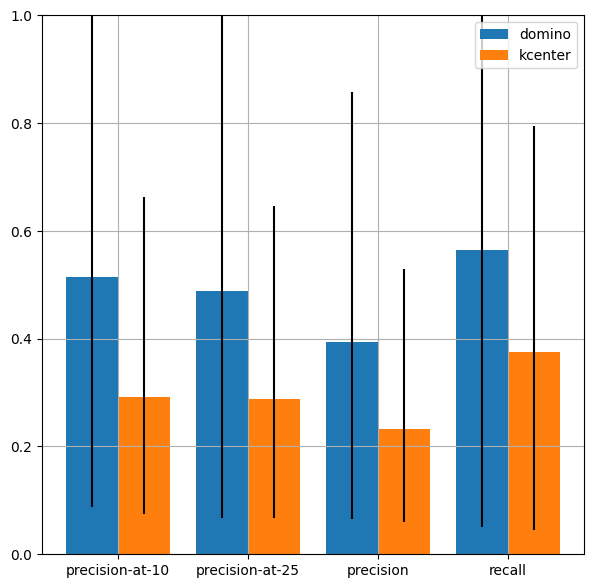

In [132]:
fig = plt.figure(figsize=(7,7))
k, m = 25, 25
domino = pd.read_csv(f'./domino_rare_results_k{k}_m{m}.csv', header=0)
domino = domino.drop(columns=['Unnamed: 0'])

kcenter = pd.read_csv(f'./kcenter_rare_results_k25.csv', header=0)
kcenter = kcenter.drop(columns=['Unnamed: 0'])

for method in ['domino', 'kcenter']:
    p10 = eval(f'{method}')['precision-at-10'].to_numpy()
    p10_ci = bootstrap_ci(p10, 0.95)

    p25 = eval(f'{method}')['precision-at-25'].to_numpy()
    p25_ci = bootstrap_ci(p25, 0.95)

    precision = eval(f'{method}')['precision'].to_numpy()
    precision_ci = bootstrap_ci(precision, 0.95)

    recall = eval(f'{method}')['recall'].to_numpy()
    recall_ci = bootstrap_ci(recall, 0.95)

    means = [p10.mean(), p25.mean(), precision.mean(), recall.mean()]

    errors = np.stack([p10_ci, p25_ci, precision_ci, recall_ci], axis=1)

    plt.bar(xpos+shift[method], means, yerr=errors, width=0.4, alpha=1, ecolor='black', label=method)

plt.grid(which='major')
plt.legend()
plt.ylim(top=1.0)
plt.xticks(xpos, metrics)
# plt.title(r"Top $\hat{k}$"+ '={} clusters from '.format(k) + r"$\bar{k}$" + "={} slices.".format(m))

plt.savefig('./kcenter_domino_rare_natural.png')
plt.show()